In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from constants import numeric_features, categorical_features
from part2.shared import load_processed_data
from part2.shared import load_train_with_validation_data
import matplotlib.pyplot as plt
from Logistic import CustomLogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [44]:
NUMBER_OF_EPOCHS = 250

In [45]:
df = load_processed_data()
df = df[df["Target"].isin(["Graduate", "Dropout"])]
df["y"] = (df["Target"] == "Graduate").astype(int)
df = df.drop(columns=["Target", "Target encoded"], errors='ignore')

In [46]:
X = df.drop(columns=["y"])
y = df["y"].values

In [47]:
num_features = [c for c in numeric_features if c in X.columns]
cat_features = [c for c in categorical_features if c in X.columns]

In [48]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [49]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [50]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [51]:
X_train_raw, X_val_raw, X_test_raw, y_train, y_val, y_test = load_train_with_validation_data(X, y)
X_train = full_pipeline.fit_transform(X_train_raw)
X_test = full_pipeline.transform(X_test_raw)
X_val = full_pipeline.transform(X_val_raw)

In [52]:
X_train = full_pipeline.fit_transform(X_train_raw)
X_val = full_pipeline.transform(X_val_raw)
X_test = full_pipeline.transform(X_test_raw)

baseline_clf = CustomLogisticRegression(
    lr=0.05,
    epochs=250,
    batch_size=64,
    verbose=False,
)

baseline_clf.fit(X_train, y_train, X_val, y_val, X_test, y_test)


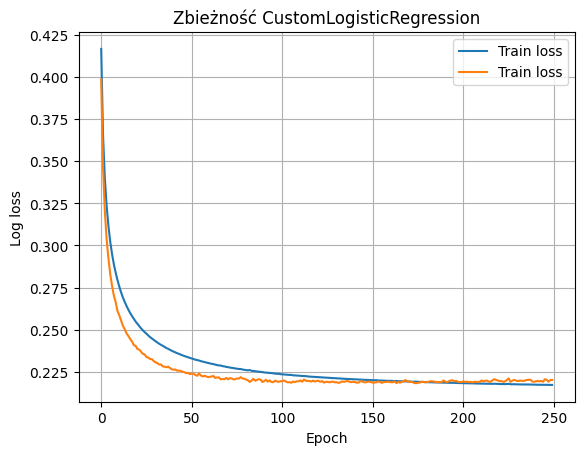

In [53]:
plt.plot(baseline_clf.history['train'], label="Train loss")
plt.plot(baseline_clf.history['test'], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.title("Zbieżność CustomLogisticRegression")
plt.legend()
plt.grid(True)
plt.show()


In [54]:
poly_pipeline = ColumnTransformer([
    ("num_poly", Pipeline([
        ("imp", SimpleImputer(strategy="mean")),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("sc", StandardScaler())
    ]), num_features),
    ("cat", cat_pipeline, cat_features)
])


In [55]:
X_train_poly = poly_pipeline.fit_transform(X_train_raw)
X_val_poly = poly_pipeline.transform(X_val_raw)
X_test_poly = poly_pipeline.transform(X_test_raw)

model_poly = CustomLogisticRegression(lr=0.05, epochs=NUMBER_OF_EPOCHS, batch_size=64, verbose=True,)
model_poly.fit(X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test)

Epoch   1/250  train_loss=0.3163  val_loss=0.2948
Epoch  20/250  train_loss=0.2351  val_loss=0.2360
Epoch  40/250  train_loss=0.2217  val_loss=0.2222
Epoch  60/250  train_loss=0.2174  val_loss=0.2096
Epoch  80/250  train_loss=0.2118  val_loss=0.2164
Epoch 100/250  train_loss=0.2082  val_loss=0.2104
Epoch 120/250  train_loss=0.2076  val_loss=0.2059
Epoch 140/250  train_loss=0.2058  val_loss=0.2202
Epoch 160/250  train_loss=0.2021  val_loss=0.2111
Epoch 180/250  train_loss=0.2016  val_loss=0.2091
Epoch 200/250  train_loss=0.2002  val_loss=0.2066
Epoch 220/250  train_loss=0.1983  val_loss=0.2084
Epoch 240/250  train_loss=0.1973  val_loss=0.2158


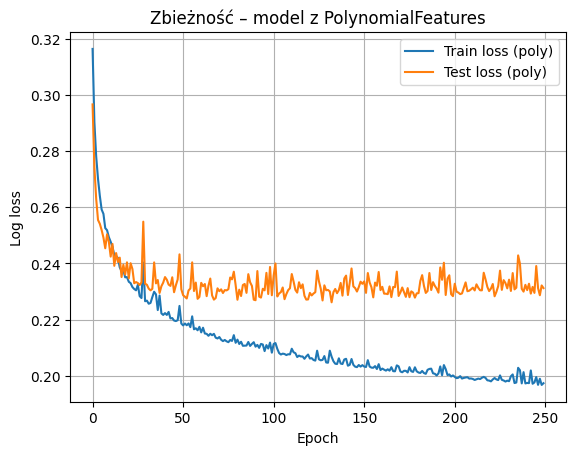

In [56]:
plt.plot(model_poly.history["train"], label="Train loss (poly)")
plt.plot(model_poly.history["test"], label="Test loss (poly)")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.title("Zbieżność – model z PolynomialFeatures")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
y_pred_poly = model_poly.predict(X_test_poly)
print(classification_report(y_test, y_pred_poly, digits=4))


              precision    recall  f1-score   support

           0     0.9051    0.8732    0.8889       284
           1     0.9205    0.9413    0.9308       443

    accuracy                         0.9147       727
   macro avg     0.9128    0.9073    0.9098       727
weighted avg     0.9145    0.9147    0.9144       727



In [58]:
select_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("selector", SelectKBest(score_func=f_classif, k=5)),
    ("scaler", StandardScaler())
])

X_train_selected = select_pipeline.fit_transform(X_train_raw[num_features], y_train)
X_val_selected = select_pipeline.transform(X_val_raw[num_features])
X_test_selected = select_pipeline.transform(X_test_raw[num_features])


model_sel = CustomLogisticRegression(lr=0.05, epochs=250, batch_size=64, verbose=True)
model_sel.fit(X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test)

Epoch   1/250  train_loss=0.4635  val_loss=0.4427
Epoch  20/250  train_loss=0.3971  val_loss=0.3667
Epoch  40/250  train_loss=0.3916  val_loss=0.3625
Epoch  60/250  train_loss=0.3896  val_loss=0.3617
Epoch  80/250  train_loss=0.3887  val_loss=0.3620
Epoch 100/250  train_loss=0.3882  val_loss=0.3623
Epoch 120/250  train_loss=0.3880  val_loss=0.3625
Epoch 140/250  train_loss=0.3878  val_loss=0.3629
Epoch 160/250  train_loss=0.3878  val_loss=0.3632
Epoch 180/250  train_loss=0.3877  val_loss=0.3633
Epoch 200/250  train_loss=0.3877  val_loss=0.3635
Epoch 220/250  train_loss=0.3877  val_loss=0.3637
Epoch 240/250  train_loss=0.3877  val_loss=0.3638


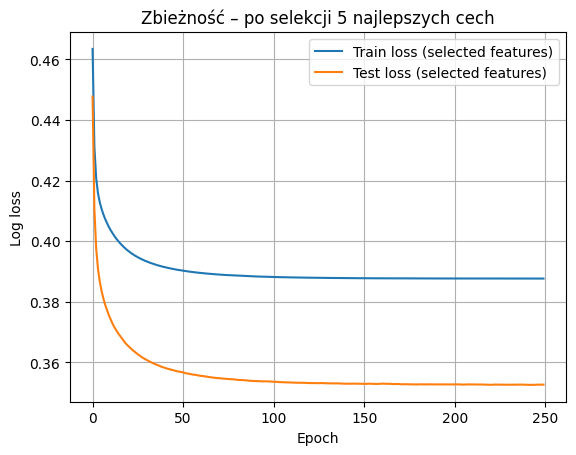

In [59]:
plt.plot(model_sel.history["train"], label="Train loss (selected features)")
plt.plot(model_sel.history["test"], label="Test loss (selected features)")
plt.title("Zbieżność – po selekcji 5 najlepszych cech")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.grid(True)
plt.show()

In [60]:
y_pred_sel = model_sel.predict(X_test_selected)
print(classification_report(y_test, y_pred_sel, digits=4))

              precision    recall  f1-score   support

           0     0.9065    0.7852    0.8415       284
           1     0.8732    0.9481    0.9091       443

    accuracy                         0.8845       727
   macro avg     0.8898    0.8666    0.8753       727
weighted avg     0.8862    0.8845    0.8827       727

